In [68]:
import torch
import torchvision.transforms as T
from PIL import Image
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import (
    Owlv2Processor, Owlv2ForObjectDetection  # works for OWLv2 & OWL-ViT
)

import warnings
warnings.filterwarnings('ignore')


# Set device to GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model_id = "IDEA-Research/grounding-dino-base"
model_id = "google/owlv2-base-patch16-ensemble"         # OWLv2 (recommended: better grounding)
# Load the pretrained DETR model and processor
owlv2_processor = Owlv2Processor.from_pretrained(model_id)
owlv2_model = Owlv2ForObjectDetection.from_pretrained(model_id).to(DEVICE).eval()


In [ ]:

# Load an image from URL or local path
image_url = "overturned red car indicating a collision.png"
#caption = "tree root lifting the pavement, creating uneven surface and potential tripping hazard"
caption = "overturned red car indicating a collision"
#image_url = f"{caption}.png"
#image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
#image = Image.open(requests.get(image_url, stream=True).raw)
image = Image.open(image_url).convert("RGB")

texts = [caption]

# Preprocess the image
inputs = owlv2_processor(images=image, text=texts, return_tensors="pt").to(DEVICE)

# Forward pass
with torch.no_grad():
    outputs = owlv2_model(**inputs)

# Post-process the results (keep only high-confidence predictions)
target_sizes = torch.tensor([image.size[::-1]])  # (height, width)
objects = owlv2_processor.post_process_grounded_object_detection(outputs, 
                                                               target_sizes=target_sizes,threshold=0.1)
results = objects[0]  # Retrieve predictions for the first image for the corresponding text queries

# for owlv2, i find logits values are all 1.0


threshold = 1.0


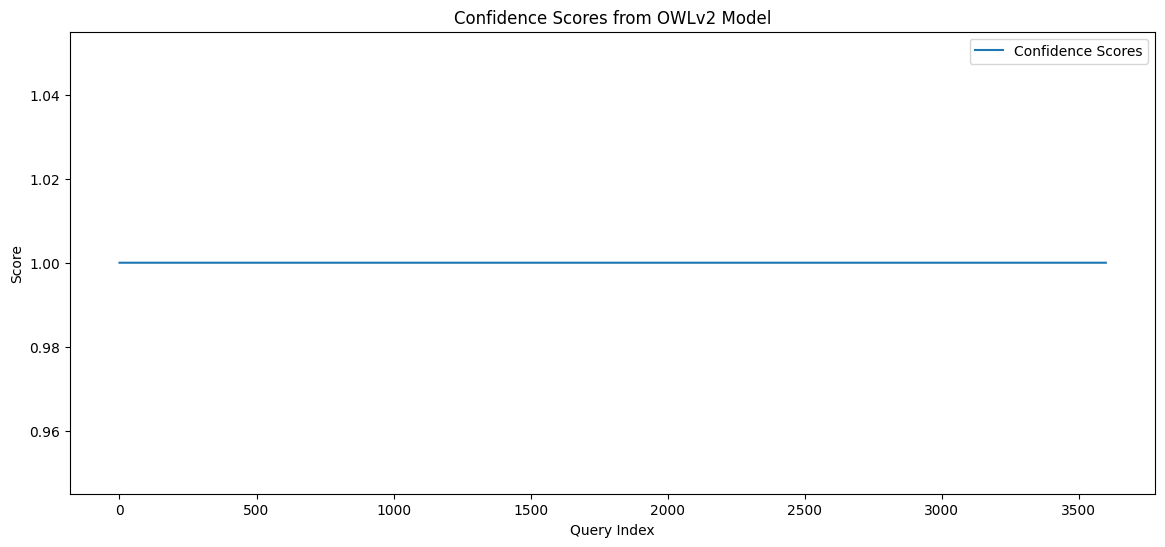

In [64]:

# Check if logits has more than one class
if outputs.logits.shape[-1] > 1:
    # Remove "no object" class and get max probability
    scores = outputs.logits.softmax(-1)[..., :-1].max(-1).values
else:
    # Only one class — just apply softmax and squeeze
    scores = outputs.logits.softmax(-1).squeeze(-1)  # shape: [1, 3600]

# Compute threshold to keep top 50% confident predictions
threshold = scores.quantile(0.5)  # median confidence
print(f"threshold = { threshold}")

# Plot scores as a line chart
plt.figure(figsize=(14, 6))
plt.plot(scores.squeeze().cpu().numpy(), label='Confidence Scores')
#plt.axhline(y=threshold.item(), color='red', linestyle='--', label='Median Threshold')
plt.title('Confidence Scores from OWLv2 Model')
plt.xlabel('Query Index')
plt.ylabel('Score')
plt.legend()


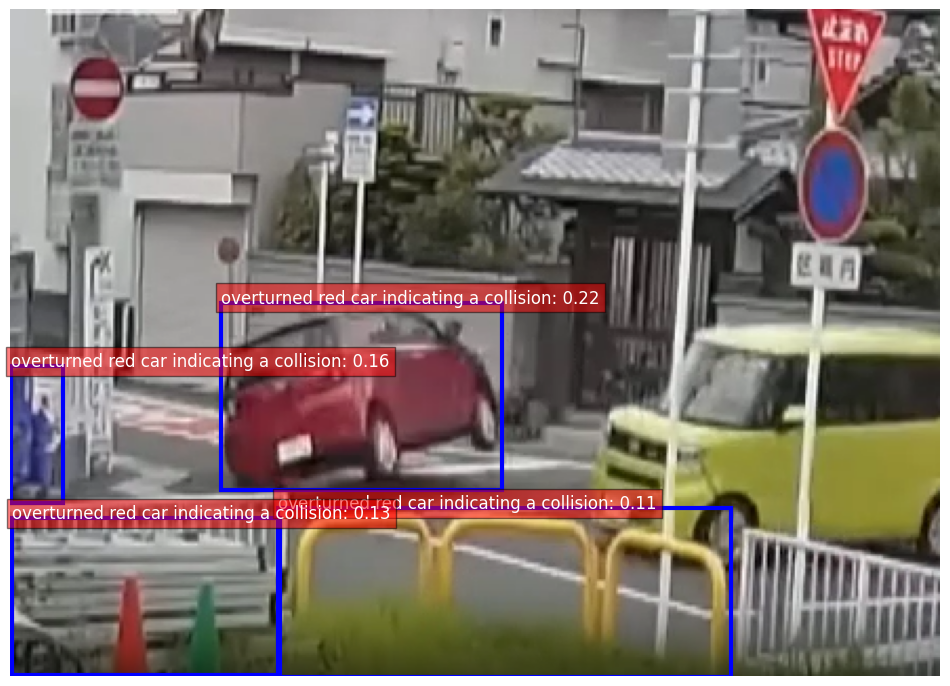

In [ ]:

# Draw results 
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    xmin, ymin, xmax, ymax = box.cpu().numpy()
    ax.add_patch(patches.Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin,
        fill=False, edgecolor='Blue', linewidth=3
    ))
    caption = f"{texts[label]}: {score:.2f}"
    ax.text(xmin, ymin, caption, fontsize=12, color='white',bbox=dict(facecolor='red', alpha=0.5))

plt.axis("off")
plt.show()


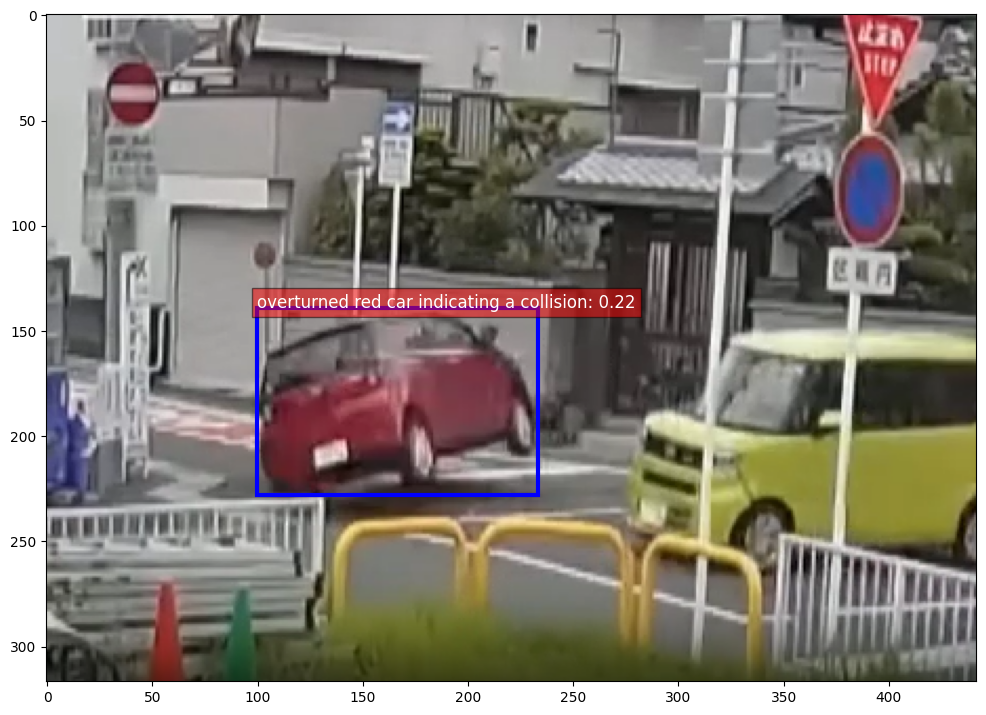

In [66]:

# Find the index of the highest scoring object
max_score_idx = results["scores"].argmax().item()

# Get the corresponding box, label, and score
box = results["boxes"][max_score_idx].cpu().numpy()
label = results["labels"][max_score_idx]
score = results["scores"][max_score_idx].item()

# Draw the image and the highest scoring box
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)

xmin, ymin, xmax, ymax = box
ax.add_patch(patches.Rectangle(
    (xmin, ymin), xmax - xmin, ymax - ymin,
    fill=False, edgecolor='blue', linewidth=3
))
caption = f"{texts[label]}: {score:.2f}"
ax.text(xmin, ymin, caption, fontsize=12, color='white',
        bbox=dict(facecolor='red', alpha=0.5))

plt.show()


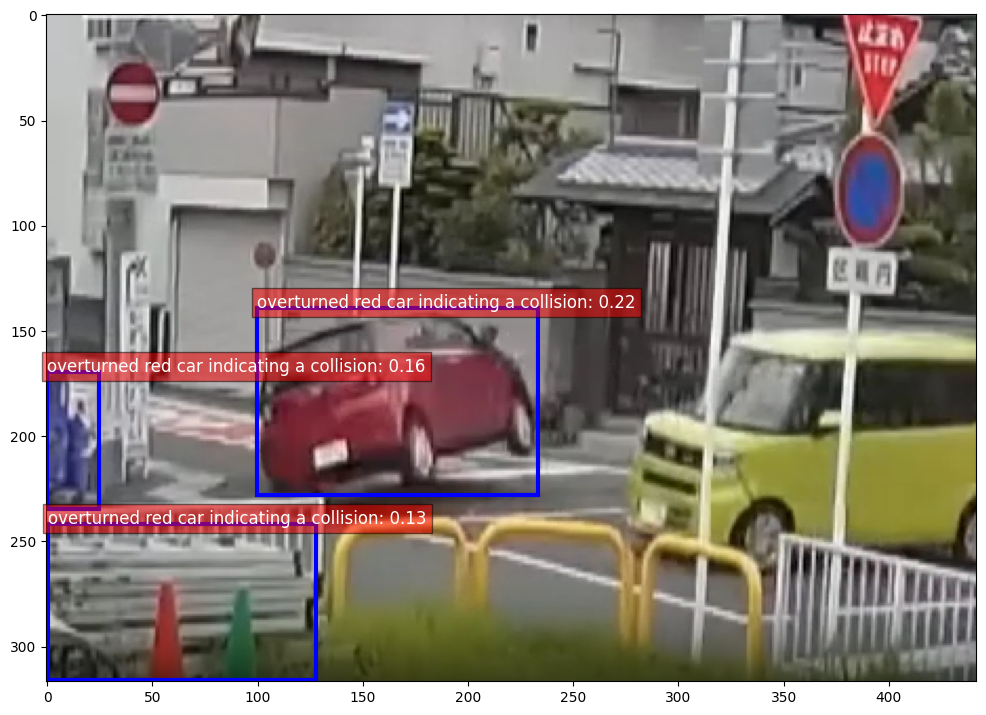

In [67]:

# スコアの高い順にインデックスを取得
top_indices = results["scores"].topk(3).indices

# 描画
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)

for idx in top_indices:
    score = results["scores"][idx].item()
    label = results["labels"][idx]
    box = results["boxes"][idx].cpu().numpy()
    xmin, ymin, xmax, ymax = box

    ax.add_patch(patches.Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin,
        fill=False, edgecolor='blue', linewidth=3
    ))
    caption = f"{texts[label]}: {score:.2f}"
    ax.text(xmin, ymin, caption, fontsize=12, color='white',
            bbox=dict(facecolor='red', alpha=0.5))

plt.show()


# tree root image


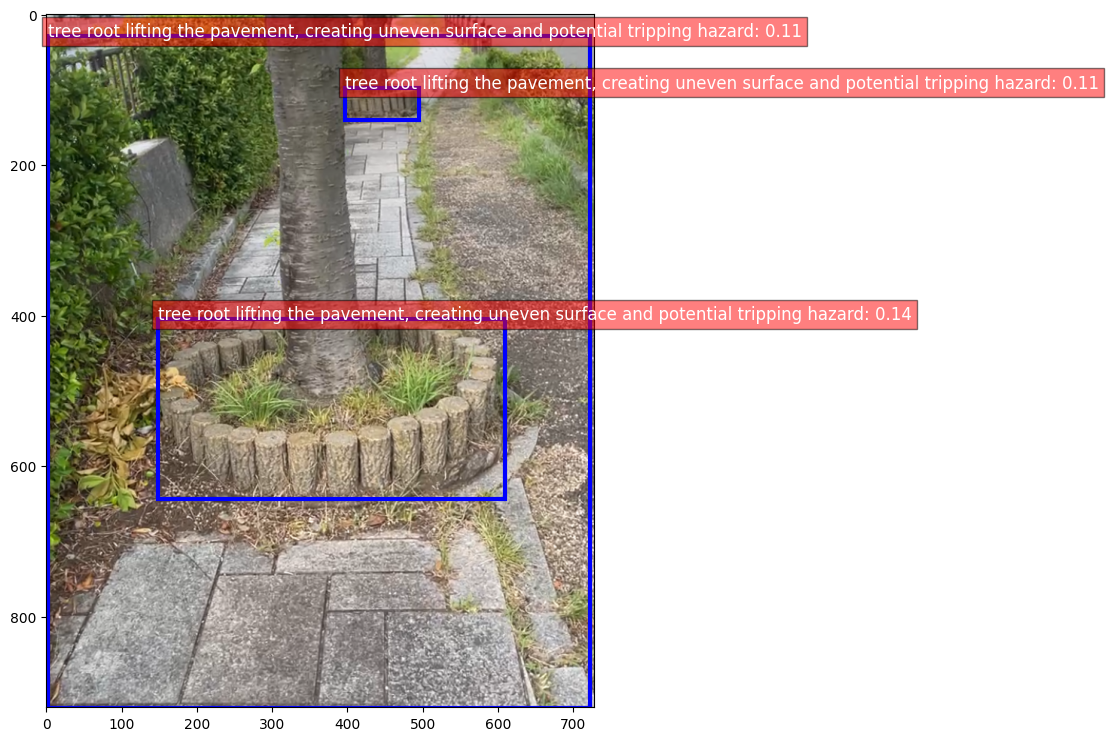

In [ ]:
# Load an image from URL or local path
image_url = "tree root lifting the pavement.png"
caption = "tree root lifting the pavement, creating uneven surface and potential tripping hazard"
image = Image.open(image_url).convert("RGB")
texts = [caption]

# Preprocess the image
inputs = owlv2_processor(images=image, text=texts, return_tensors="pt").to(DEVICE)

# Forward pass
with torch.no_grad():
    outputs = owlv2_model(**inputs)

# Post-process the results (keep only high-confidence predictions)
target_sizes = torch.tensor([image.size[::-1]])  # (height, width)
objects = owlv2_processor.post_process_grounded_object_detection(outputs,                                                            target_sizes=target_sizes,threshold=0.1)

results = objects[0]  # Retrieve predictions for the first image for the corresponding text queries

# スコアの高い順にインデックスを取得
top_indices = results["scores"].topk(3).indices

# 描画
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)

for idx in top_indices:
    score = results["scores"][idx].item()
    label = results["labels"][idx]
    box = results["boxes"][idx].cpu().numpy()
    xmin, ymin, xmax, ymax = box

    ax.add_patch(patches.Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin,
        fill=False, edgecolor='blue', linewidth=3
    ))
    caption = f"{texts[label]}: {score:.2f}"
    ax.text(xmin, ymin, caption, fontsize=12, color='white',
            bbox=dict(facecolor='red', alpha=0.5))

plt.show()


In [71]:
results

{'scores': tensor([0.1083, 0.1431, 0.1017, 0.1065], device='cuda:0'),
 'labels': tensor([0, 0, 0, 0], device='cuda:0'),
 'boxes': tensor([[396.4545,  97.3937, 495.0858, 139.9977],
         [148.0027, 404.7664, 609.2025, 643.4874],
         [ 37.4927, 464.7774, 194.6132, 660.8889],
         [  1.5514,  28.8654, 722.0370, 922.0033]], device='cuda:0'),
 'text_labels': None}